In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

In [9]:
# 1. Load Train & Test Datasets
train_df = pd.read_csv("D:/Mini Project/stress-chatbot/phase1_model/data/dreaddit-train.csv")
test_df = pd.read_csv("D:/Mini Project/stress-chatbot/phase1_model/data/dreaddit-test.csv")

X_train, y_train = train_df["text"], train_df["label"]
X_test, y_test = test_df["text"], test_df["label"]


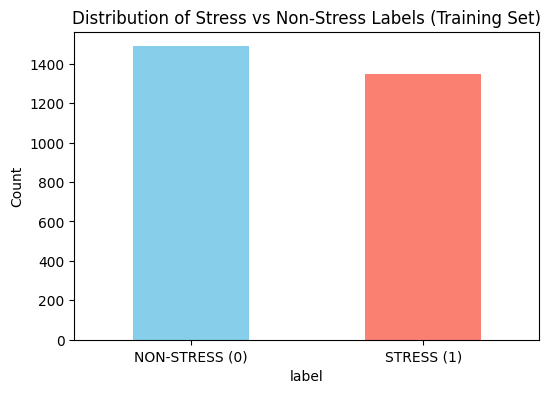

📊 Label Distribution:
label
1    1488
0    1350
Name: count, dtype: int64

⚖️ Balance Ratio (each class %):
label
1    52.43129
0    47.56871
Name: count, dtype: float64

✅ Dataset is relatively balanced


In [11]:
# Count labels
label_counts = train_df['label'].value_counts()

# Bar plot of labels
plt.figure(figsize=(6,4))
label_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.xticks([0,1], ['NON-STRESS (0)', 'STRESS (1)'], rotation=0)
plt.ylabel("Count")
plt.title("Distribution of Stress vs Non-Stress Labels (Training Set)")
plt.show()

# Check dataset balance
total = label_counts.sum()
balance_ratio = label_counts / total
print("📊 Label Distribution:")
print(label_counts)
print("\n⚖️ Balance Ratio (each class %):")
print(balance_ratio * 100)

# Quick check if dataset is balanced
if balance_ratio.min() < 0.4:
    print("\n⚠️ Dataset is imbalanced (one class < 40%)")
else:
    print("\n✅ Dataset is relatively balanced")


In [12]:
# 2. TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=2050, stop_words="english")
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [16]:
# 3. Logistic Regression Model (tuned)
model = LogisticRegression(
    C=0.5,
    #solver="liblinear",
    max_iter=200,
    class_weight="balanced"
)
model.fit(X_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.5
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,200
,multi_class,'deprecated'


In [17]:
# 4. Prediction
y_pred = model.predict(X_test_tfidf)

✅ Training Accuracy: 0.8439041578576463

📊 Training Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.86      0.84      1350
           1       0.87      0.83      0.85      1488

    accuracy                           0.84      2838
   macro avg       0.84      0.84      0.84      2838
weighted avg       0.84      0.84      0.84      2838



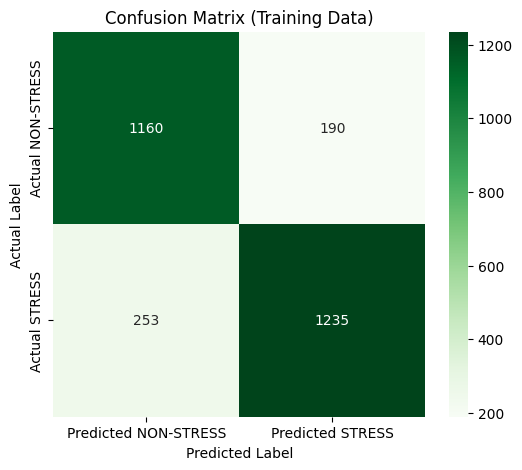

Final Test Accuracy: 0.7314685314685314

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.72      0.72       346
           1       0.74      0.75      0.74       369

    accuracy                           0.73       715
   macro avg       0.73      0.73      0.73       715
weighted avg       0.73      0.73      0.73       715



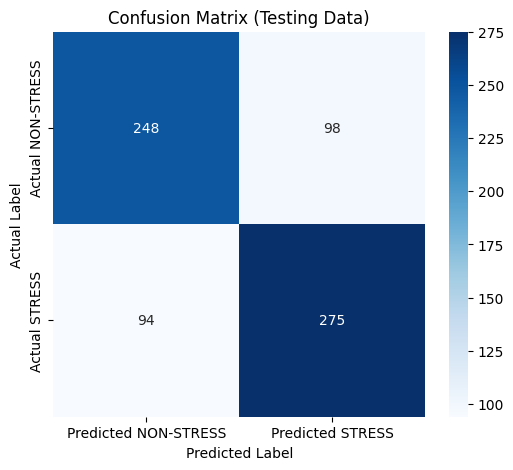

In [25]:
# 5. Evaluation
y_train_pred = model.predict(X_train_tfidf)
train_acc = accuracy_score(y_train, y_train_pred)
print("✅ Training Accuracy:", train_acc)
print("\n📊 Training Classification Report:\n", classification_report(y_train, y_train_pred))
cm_train = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicted NON-STRESS', 'Predicted STRESS'],
            yticklabels=['Actual NON-STRESS', 'Actual STRESS'])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix (Training Data)")
plt.show()



acc = accuracy_score(y_test, y_pred)
print("Final Test Accuracy:", acc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)


# Plot confusion matrix with labels
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted NON-STRESS', 'Predicted STRESS'],
            yticklabels=['Actual NON-STRESS', 'Actual STRESS'])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix (Testing Data)")
plt.show()

In [11]:
# 7. Save Model + Vectorizer
joblib.dump(model, "logistic_stress_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
print("Model & Vectorizer saved successfully!")

Model & Vectorizer saved successfully!


In [12]:
# 8. Demo: Custom Threshold (for practical chatbot use)

def classify_text_with_threshold(text, model, tfidf, threshold=0.4):
    """
    Apply a custom threshold to Logistic Regression predictions.
    Default sklearn uses 0.5.
    Here we lock to 0.4 for better stress sensitivity.
    """
    vec = tfidf.transform([text])
    probs = model.predict_proba(vec)[0]  # [non-stress_prob, stress_prob]
    stress_prob = probs[1]

    if stress_prob >= threshold:
        prediction = "STRESS"
    else:
        prediction = "NON-STRESS"

    return prediction, probs


# 🔍 Example usage
sample_texts = [
    "I will fail in tomorrow's exam what to do?",
    "It's a nice sunny day, I feel relaxed.",
    "Which is the capital of China?",
    "what is your name",
    " i have exam and placement drive tomorrow, to which i will give more importance for exam or placement drive, i am confused please help me"
]

for text in sample_texts:
    prediction, probs = classify_text_with_threshold(text, model, tfidf, threshold=0.4)
    print("\nSample Input:", text)
    print("→ Prediction:", prediction)
    print("→ Probabilities:", probs)



Sample Input: I will fail in tomorrow's exam what to do?
→ Prediction: STRESS
→ Probabilities: [0.58389045 0.41610955]

Sample Input: It's a nice sunny day, I feel relaxed.
→ Prediction: STRESS
→ Probabilities: [0.42812964 0.57187036]

Sample Input: Which is the capital of China?
→ Prediction: NON-STRESS
→ Probabilities: [0.63622276 0.36377724]

Sample Input: what is your name
→ Prediction: NON-STRESS
→ Probabilities: [0.63622276 0.36377724]

Sample Input:  i have exam and placement drive tomorrow, to which i will give more importance for exam or placement drive, i am confused please help me
→ Prediction: STRESS
→ Probabilities: [0.58625517 0.41374483]


In [14]:
from sklearn.metrics import log_loss

# Transform test set using the trained vectorizer
X_test_tfidf = tfidf.transform(X_test)

# Get predicted probabilities
y_probs = model.predict_proba(X_test_tfidf)

# Calculate log loss
loss = log_loss(y_test, y_probs)
print("\nLog Loss on Test Set:", loss)



Log Loss on Test Set: 0.567731047926417


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

train_df = pd.read_csv("D:/Mini Project/stress-chatbot/phase1_model/data/dreaddit-train.csv")
test_df = pd.read_csv("D:/Mini Project/stress-chatbot/phase1_model/data/dreaddit-test.csv")

X_train, y_train = train_df["text"], train_df["label"]
X_test, y_test = test_df["text"], test_df["label"]


In [7]:
train_df[['text','label']].head()

,text,label
0,"He said he had not felt that way before, sugge...",1
1,"Hey there r/assistance, Not sure if this is th...",0
2,My mom then hit me with the newspaper and it s...,1
3,"until i met my new boyfriend, he is amazing, h...",1
4,October is Domestic Violence Awareness Month a...,1


In [2]:
label_counts = train_df['label'].value_counts()
print(label_counts)

label
1    1488
0    1350
Name: count, dtype: int64


In [3]:
train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))
train_df['text_length'].describe()


count    2838.000000
mean       85.669838
std        32.292305
min         1.000000
25%        65.000000
50%        80.000000
75%       101.000000
max       310.000000
Name: text_length, dtype: float64

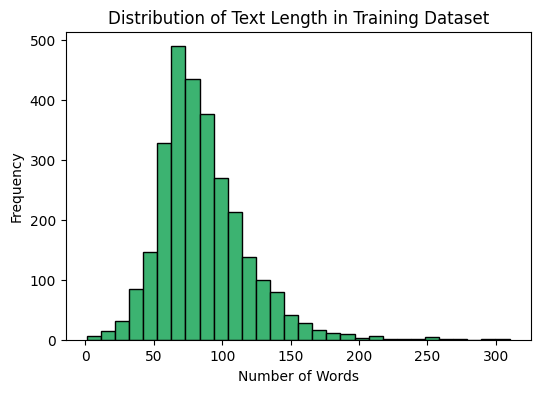

In [6]:
train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(6,4))
plt.hist(train_df['text_length'], bins=30, color='mediumseagreen', edgecolor='black')
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.title("Distribution of Text Length in Training Dataset")
plt.show()


In [8]:
# TF-IDF Vectorization
# ------------------------------
tfidf = TfidfVectorizer(max_features=2050, stop_words="english")
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# ------------------------------
# Logistic Regression Model
# ------------------------------
model = LogisticRegression(
    C=0.5,
    max_iter=200,
    class_weight="balanced"
)
model.fit(X_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.5
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,200
,multi_class,'deprecated'


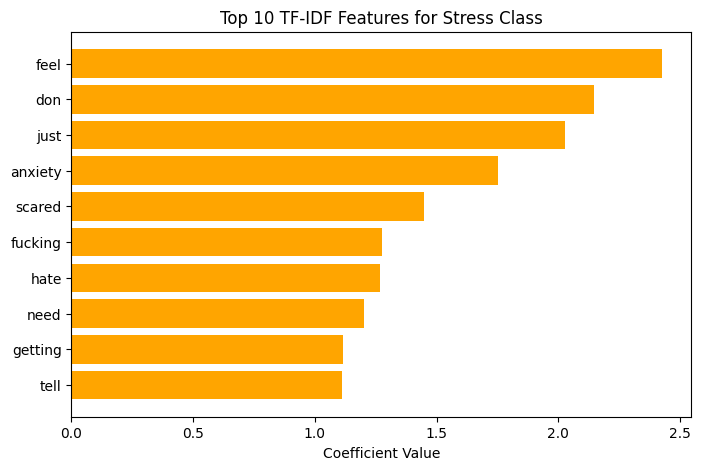

In [9]:
coefficients = model.coef_[0]
features = tfidf.get_feature_names_out()
top_features_idx = np.argsort(coefficients)[-10:]  # top 10 positive coefficients

plt.figure(figsize=(8,5))
plt.barh([features[i] for i in top_features_idx], coefficients[top_features_idx], color='orange')
plt.xlabel("Coefficient Value")
plt.title("Top 10 TF-IDF Features for Stress Class")
plt.show()


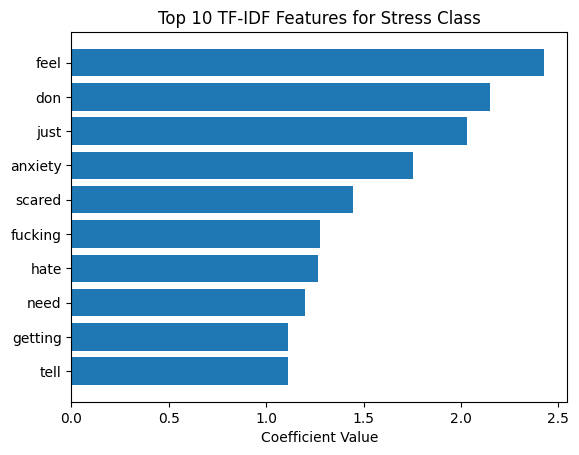

In [10]:
import matplotlib.pyplot as plt
import numpy as np

coefficients = model.coef_[0]
features = tfidf.get_feature_names_out()
top_features_idx = np.argsort(coefficients)[-10:]
plt.barh([features[i] for i in top_features_idx], coefficients[top_features_idx])
plt.title("Top 10 TF-IDF Features for Stress Class")
plt.xlabel("Coefficient Value")
plt.show()


In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = model.predict(X_test_tfidf)
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)
print(classification_report(y_test, y_pred))


Test Accuracy: 0.7314685314685314
              precision    recall  f1-score   support

           0       0.73      0.72      0.72       346
           1       0.74      0.75      0.74       369

    accuracy                           0.73       715
   macro avg       0.73      0.73      0.73       715
weighted avg       0.73      0.73      0.73       715



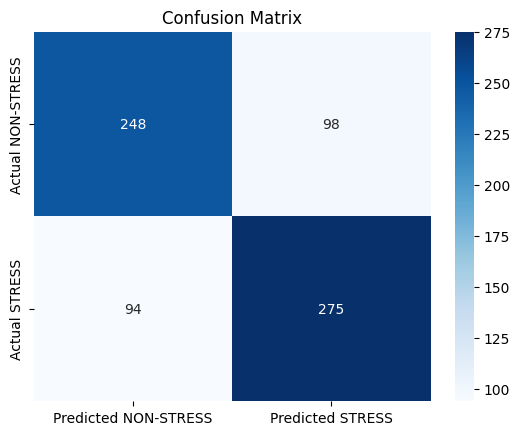

In [12]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted NON-STRESS', 'Predicted STRESS'],
            yticklabels=['Actual NON-STRESS', 'Actual STRESS'])
plt.title("Confusion Matrix")
plt.show()


In [ ]:
def classify_text_with_threshold(text, model, tfidf, threshold=0.4):
    vec = tfidf.transform([text])
    probs = model.predict_proba(vec)[0]
    stress_prob = probs[1]
    return "STRESS" if stress_prob >= threshold else "NON-STRESS", probs


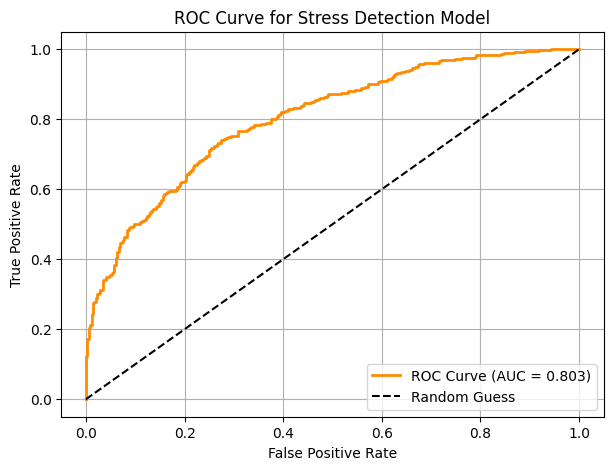

In [13]:
# ------------------------------
# ROC Curve for Stress Classifier
# ------------------------------

from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities
y_prob = model.predict_proba(X_test_tfidf)[:, 1]  # probability of stress (class = 1)

# Compute ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC Curve
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})', color='darkorange', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Stress Detection Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


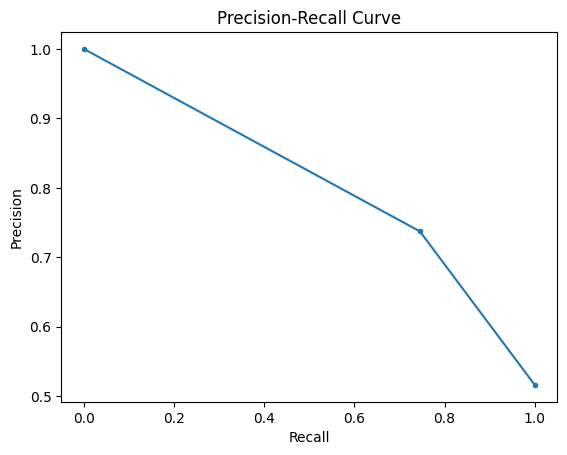

AUC-PR: 0.8069956997963276


In [15]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

pr_auc = auc(recall, precision)
print("AUC-PR:", pr_auc)


In [1]:
df.head()

NameError: name 'df' is not defined

In [27]:
train_acc = accuracy_score(y_train, y_train_pred)
print("✅ Training Accuracy:", train_acc)
print("\n📊 Training Classification Report:\n", classification_report(y_train, y_train_pred))
cm_train = confusion_matrix(y_train, y_train_pred)


✅ Training Accuracy: 0.8439041578576463

📊 Training Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.86      0.84      1350
           1       0.87      0.83      0.85      1488

    accuracy                           0.84      2838
   macro avg       0.84      0.84      0.84      2838
weighted avg       0.84      0.84      0.84      2838



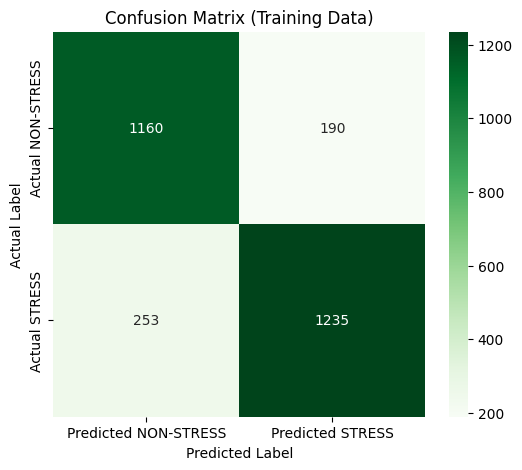

In [28]:
plt.figure(figsize=(6,5))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicted NON-STRESS', 'Predicted STRESS'],
            yticklabels=['Actual NON-STRESS', 'Actual STRESS'])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix (Training Data)")
plt.show()
